In [7]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow logs

import torch
import json
import os
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from transformers import ViTModel
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dataset class
class PoseDataset(Dataset):
    def __init__(self, json_path, image_root, transform=None):
        with open(json_path, "r") as f:
            self.data = json.load(f)
        self.image_root = image_root
        self.transform = transform
        self.images = {img["id"]: img for img in self.data["images"]}
        self.annotations = self.data["annotations"]

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        ann = self.annotations[idx]
        image_info = self.images[ann["image_id"]]
        image_path = os.path.join(self.image_root, image_info["file_name"])

        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        keypoints = torch.tensor(ann["keypoints"], dtype=torch.float32).view(-1, 3)
        keypoints[:, 0] /= image_info["width"]
        keypoints[:, 1] /= image_info["height"]
        return image, keypoints, image_info["width"], image_info["height"]

# Define transform with augmentations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(15),  # Randomly rotate images
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),  # Random shifts
    transforms.RandomHorizontalFlip(),  # Mirror the image
    transforms.ColorJitter(brightness=0.3, contrast=0.3),  # More brightness variation
    transforms.ToTensor()
])

# Load datasets for train, validation, and test
train_dataset = PoseDataset(
    image_root='/mnt/c/Users/Owner/Downloads/Excersise Dataset.v4i.coco/train',
    json_path='/mnt/c/Users/Owner/Downloads/Excersise Dataset.v4i.coco/train/_annotations.coco.json',
    transform=transform
)

val_dataset = PoseDataset(
    image_root='/mnt/c/Users/Owner/Downloads/Excersise Dataset.v4i.coco/valid',
    json_path='/mnt/c/Users/Owner/Downloads/Excersise Dataset.v4i.coco/valid/_annotations.coco.json',
    transform=transform
)

test_dataset = PoseDataset(
    image_root='/mnt/c/Users/Owner/Downloads/Excersise Dataset.v4i.coco/test',
    json_path='/mnt/c/Users/Owner/Downloads/Excersise Dataset.v4i.coco/test/_annotations.coco.json',
    transform=transform
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Define ViT-based model
class ViTPose(nn.Module):
    def __init__(self, num_keypoints=6):
        super(ViTPose, self).__init__()
        self.vit = ViTModel.from_pretrained("facebook/dino-vitb16")
        self.mlp_head = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Linear(512, num_keypoints * 2)
        )
    
    def forward(self, images):
        features = self.vit(images).last_hidden_state[:, 0, :]
        keypoints = self.mlp_head(features)
        return keypoints.view(-1, 6, 2)

# Initialize model
model = ViTPose().to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

# Metrics functions
def calculate_mpjpe(pred_keypoints, gt_keypoints):
    """
    Calculate Mean Per Joint Position Error (MPJPE).
    """
    return torch.mean(torch.norm(pred_keypoints - gt_keypoints, dim=-1))

def calculate_pck(pred_keypoints, gt_keypoints, threshold=0.2):
    """
    Calculate Percentage of Correct Keypoints (PCK) within a threshold.
    """
    distances = torch.norm(pred_keypoints - gt_keypoints, dim=-1)
    return torch.mean((distances < threshold).float()) * 100

def calculate_oks(pred_keypoints, gt_keypoints, scale, kappa=0.5):
    """
    Calculate Object Keypoint Similarity (OKS).
    """
    distances = torch.norm(pred_keypoints - gt_keypoints, dim=-1)
    scale = scale.unsqueeze(1)  # Ensure scale has shape (batch_size, 1) to broadcast
    oks = torch.exp(-(distances ** 2) / (2 * (scale ** 2) * (kappa ** 2)))
    return torch.mean(oks)

def calculate_nme(pred_keypoints, gt_keypoints, normalization_factor):
    """
    Calculate Normalized Mean Error (NME).
    """
    distances = torch.norm(pred_keypoints - gt_keypoints, dim=-1)
    return torch.mean(distances / normalization_factor)

def calculate_failure_rate(pred_keypoints, gt_keypoints, threshold=0.5):
    """
    Calculate Failure Rate (percentage of predictions with OKS below a threshold).
    """
    distances = torch.norm(pred_keypoints - gt_keypoints, dim=-1)
    oks = torch.exp(-(distances ** 2) / (2 * (threshold ** 2)))
    return torch.mean((oks < threshold).float()) * 100

def calculate_kda(pred_keypoints, gt_keypoints, threshold=5):
    """
    Calculate Keypoint Detection Accuracy (KDA) within a pixel threshold.
    """
    distances = torch.norm(pred_keypoints - gt_keypoints, dim=-1)
    return torch.mean((distances < threshold).float()) * 100

def calculate_ap_ar(pred_keypoints, gt_keypoints, scale, thresholds=[0.50, 0.75]):
    """
    Calculate Average Precision (AP) and Average Recall (AR) using OKS thresholds.
    """
    oks_values = []
    for threshold in thresholds:
        oks = calculate_oks(pred_keypoints, gt_keypoints, scale)
        oks_values.append((oks > threshold).float().mean().item())

    ap = sum(oks_values) / len(oks_values)  # Mean AP over thresholds
    ar = max(oks_values)  # AR is the max recall at the best threshold
    return ap * 100, ar * 100  # Convert to percentage


# def calculate_kva(pred_visibility, gt_visibility):
#     """
#     Calculate Keypoint Visibility Accuracy (KVA).
#     """
#     return torch.mean((pred_visibility == gt_visibility).float()) * 100


# Define the checkpoint path
CHECKPOINT_PATH = "best_model.pth"


# Training function
def train(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.train()
    best_val_loss = float("inf")  # Track the best validation loss

    for epoch in range(epochs):
        total_train_loss = 0
        total_val_loss = 0
        total_mpjpe = 0
        total_pck = 0
        total_oks = 0
        total_nme = 0
        total_failure_rate = 0
        total_kda = 0
        total_kva = 0
        total_ap = 0
        total_ar = 0

        
        # Training loop
        for images, keypoints, _, _ in train_loader:
            images, keypoints = images.to(device), keypoints.to(device)
            optimizer.zero_grad()
            predictions = model(images)
            loss = criterion(predictions, keypoints[:, :, :2])
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        # Validation loop
        model.eval()
        with torch.no_grad():
            for images, keypoints, width, height in val_loader:
                images, keypoints = images.to(device), keypoints.to(device)
                predictions = model(images)

                # Calculate validation loss
                loss = criterion(predictions, keypoints[:, :, :2])
                total_val_loss += loss.item()

                # Calculate metrics
                pred_keypoints = predictions.cpu()
                gt_keypoints = keypoints[:, :, :2].cpu()
                scale = torch.sqrt(width * height).cpu().unsqueeze(1)  # Shape: (batch_size, 1)  # Scale factor for OKS
                # Convert width and height to tensors properly
                width = torch.tensor(width, dtype=torch.float32)
                height = torch.tensor(height, dtype=torch.float32)
                normalization_factor = ((width + height) / 2).cpu().unsqueeze(1)  # Compute mean directly

                # normalization_factor = torch.tensor([width, height]).mean().cpu()  # For NME

                total_mpjpe += calculate_mpjpe(pred_keypoints, gt_keypoints).item()
                total_pck += calculate_pck(pred_keypoints, gt_keypoints).item()
                total_oks += calculate_oks(pred_keypoints, gt_keypoints, scale).item()
                total_nme += calculate_nme(pred_keypoints, gt_keypoints, normalization_factor).item()
                total_failure_rate += calculate_failure_rate(pred_keypoints, gt_keypoints).item()
                total_kda += calculate_kda(pred_keypoints, gt_keypoints).item()
                # total_kva += calculate_kva(pred_keypoints[:, :, 2], gt_keypoints[:, :, 2]).item()

                # Compute AP and AR
                ap, ar = calculate_ap_ar(pred_keypoints, gt_keypoints, scale)
                total_ap += ap
                total_ar += ar
        
        model.train()  # Set back to training mode
        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)  # 🔥 Ensure avg_val_loss is computed
 
        avg_ap = total_ap / len(val_loader)
        avg_ar = total_ar / len(val_loader)
        # Print metrics
        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Train Loss: {total_train_loss / len(train_loader):.6f}, "
              f"Val Loss: {total_val_loss / len(val_loader):.6f}, "
              f"MPJPE: {total_mpjpe / len(val_loader):.6f}, "
              f"PCK: {total_pck / len(val_loader):.6f}, "
              f"OKS: {total_oks / len(val_loader):.6f}, "
              f"NME: {total_nme / len(val_loader):.6f}, "
              f"Failure Rate: {total_failure_rate / len(val_loader):.6f}, "
              f"KDA: {total_kda / len(val_loader):.6f}, "
              # f"KVA: {total_kva / len(val_loader):.6f}")
              f"AP: {total_ap / len(val_loader):.6f}, "
              f"AR: {total_ar / len(val_loader):.6f}")
                # **SAVE CHECKPOINT IF THIS IS THE BEST VALIDATION LOSS**
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), CHECKPOINT_PATH)
            print(f"🔥 New best model saved with val_loss {best_val_loss:.6f}")
            
# Run the training with validation
train(model, train_loader, val_loader, criterion, optimizer, epochs=20)



Using device: cuda


Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_1043/4256285050.py:220: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  width = torch.tensor(width, dtype=torch.float32)
/tmp/ipykernel_1043/4256285050.py:221: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  height = torch.tensor(height, dtype=torch.float32)


Epoch [1/20], Train Loss: 0.068575, Val Loss: 0.016215, MPJPE: 0.156186, PCK: 71.726187, OKS: 1.000000, NME: 0.000293, Failure Rate: 0.000000, KDA: 100.000000, AP: 100.000000, AR: 100.000000
🔥 New best model saved with val_loss 0.016215
Epoch [2/20], Train Loss: 0.009034, Val Loss: 0.008913, MPJPE: 0.111376, PCK: 87.946431, OKS: 1.000000, NME: 0.000210, Failure Rate: 0.000000, KDA: 100.000000, AP: 100.000000, AR: 100.000000
🔥 New best model saved with val_loss 0.008913
Epoch [3/20], Train Loss: 0.005705, Val Loss: 0.007213, MPJPE: 0.099921, PCK: 90.823415, OKS: 1.000000, NME: 0.000188, Failure Rate: 0.000000, KDA: 100.000000, AP: 100.000000, AR: 100.000000
🔥 New best model saved with val_loss 0.007213
Epoch [4/20], Train Loss: 0.004770, Val Loss: 0.006965, MPJPE: 0.098990, PCK: 91.617064, OKS: 1.000000, NME: 0.000186, Failure Rate: 0.000000, KDA: 100.000000, AP: 100.000000, AR: 100.000000
🔥 New best model saved with val_loss 0.006965
Epoch [5/20], Train Loss: 0.003829, Val Loss: 0.0062

/tmp/ipykernel_1043/2715981723.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(CHECKPOINT_PATH))


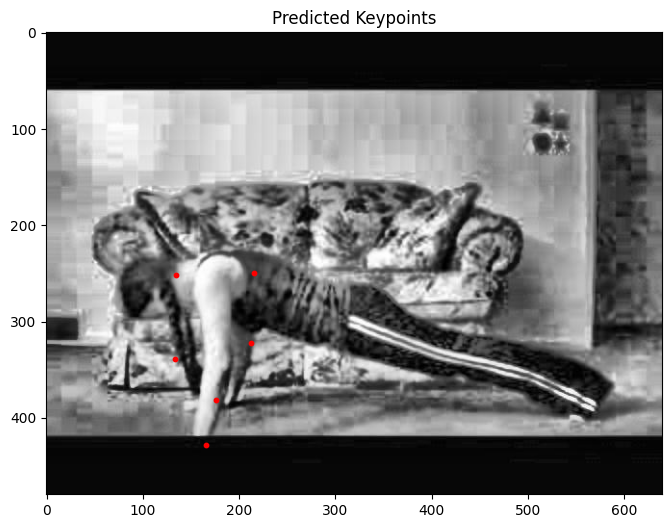

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
from PIL import Image

# Load the best checkpoint before visualizing
CHECKPOINT_PATH = "best_model.pth"
model.load_state_dict(torch.load(CHECKPOINT_PATH))
model.to(device)
model.eval()

def visualize_predictions(model, dataset, sample_idx=0):
    """
    Visualizes keypoint predictions on a sample image from the dataset.
    """
    model.eval()
    
    # Load image and keypoints
    sample_image, sample_keypoints, width, height = dataset[sample_idx]
    sample_image = sample_image.unsqueeze(0).to(device)

    # Get predictions
    with torch.no_grad():
        predicted_keypoints = model(sample_image).cpu().numpy().reshape(-1, 2)

    # Scale keypoints back to original image size
    predicted_keypoints[:, 0] *= width
    predicted_keypoints[:, 1] *= height

    # Load original image
    image_info = dataset.images[dataset.annotations[sample_idx]["image_id"]]
    image_path = os.path.join(dataset.image_root, image_info["file_name"])
    sample_image_pil = Image.open(image_path).convert("RGB")

    # Convert PIL image to NumPy for plotting
    sample_image_np = np.array(sample_image_pil)

    # Plot keypoints on the original image
    plt.figure(figsize=(8, 6))
    plt.imshow(sample_image_np)
    plt.scatter(predicted_keypoints[:, 0], predicted_keypoints[:, 1], c='r', s=10)
    plt.title("Predicted Keypoints")
    plt.show()

# **Call the function for visualization using the saved model**
visualize_predictions(model, test_dataset, sample_idx=5)


/tmp/ipykernel_1043/734921573.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(CHECKPOINT_PATH))


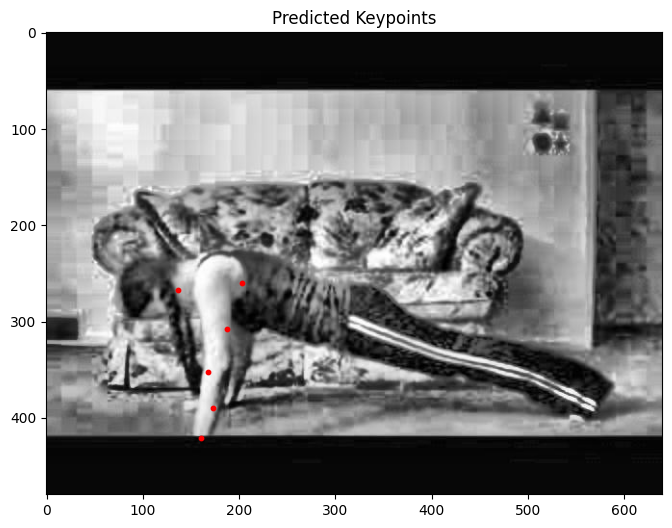

In [14]:
# Visualization function

# Load the best checkpoint before visualizing
CHECKPOINT_PATH = "best_model.pth"
model.load_state_dict(torch.load(CHECKPOINT_PATH))
model.to(device)
model.eval()

def visualize_predictions(model, dataset, sample_idx=0):
    model.eval()
    
    # Load image and keypoints
    sample_image, sample_keypoints, width, height = dataset[sample_idx]
    sample_image = sample_image.unsqueeze(0).to(device)

    # Get predictions
    with torch.no_grad():
        predicted_keypoints = model(sample_image).cpu().numpy().reshape(-1, 2)

    # Scale keypoints back to original image size
    predicted_keypoints[:, 0] *= width
    predicted_keypoints[:, 1] *= height

    # Load original image
    image_info = dataset.images[dataset.annotations[sample_idx]["image_id"]]
    image_path = os.path.join(dataset.image_root, image_info["file_name"])
    sample_image_pil = Image.open(image_path).convert("RGB")

    # Convert PIL image to NumPy for plotting
    sample_image_np = np.array(sample_image_pil)

    # Plot keypoints on original image
    plt.figure(figsize=(8, 6))
    plt.imshow(sample_image_np)
    plt.scatter(predicted_keypoints[:, 0], predicted_keypoints[:, 1], c='r', s=10)
    plt.title("Predicted Keypoints")
    plt.show()

# Call the function for visualization
visualize_predictions(model, test_dataset, sample_idx=5)

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow logs


import torch
import json
import os
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from transformers import ViTFeatureExtractor, ViTModel
from PIL import Image
import torch.nn as nn
import torch.optim as optim

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dataset class
class PoseDataset(Dataset):
    def __init__(self, json_path, image_root, transform=None):
        with open(json_path, "r") as f:
            self.data = json.load(f)
        self.image_root = image_root
        self.transform = transform
        self.images = {img["id"]: img for img in self.data["images"]}
        self.annotations = self.data["annotations"]

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        ann = self.annotations[idx]
        image_info = self.images[ann["image_id"]]
        image_path = os.path.join(self.image_root, image_info["file_name"])

        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        keypoints = torch.tensor(ann["keypoints"], dtype=torch.float32).view(-1, 3)
        keypoints[:, 0] /= image_info["width"]
        keypoints[:, 1] /= image_info["height"]
        return image, keypoints

# Define transform with augmentations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(15),  # Randomly rotate images
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),  # Random shifts
    transforms.RandomHorizontalFlip(),  # Mirror the image
    transforms.ColorJitter(brightness=0.3, contrast=0.3),  # More brightness variation
    transforms.ToTensor()
])

# Load datasets for train, validation, and test
train_dataset = PoseDataset(
    image_root='/mnt/c/Users/Owner/Downloads/Excersise Dataset.v4i.coco/train',
    json_path='/mnt/c/Users/Owner/Downloads/Excersise Dataset.v4i.coco/train/_annotations.coco.json',
    transform=transform
)

val_dataset = PoseDataset(
    image_root='/mnt/c/Users/Owner/Downloads/Excersise Dataset.v4i.coco/valid',
    json_path='/mnt/c/Users/Owner/Downloads/Excersise Dataset.v4i.coco/valid/_annotations.coco.json',
    transform=transform
)

test_dataset = PoseDataset(
    image_root='/mnt/c/Users/Owner/Downloads/Excersise Dataset.v4i.coco/test',
    json_path='/mnt/c/Users/Owner/Downloads/Excersise Dataset.v4i.coco/test/_annotations.coco.json',
    transform=transform
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Define ViT-based model
class ViTPose(nn.Module):
    def __init__(self, num_keypoints=6):
        super(ViTPose, self).__init__()
        self.vit = ViTModel.from_pretrained("facebook/dino-vitb16")
        self.mlp_head = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Linear(512, num_keypoints * 2)
        )
    
    def forward(self, images):
        features = self.vit(images).last_hidden_state[:, 0, :]
        keypoints = self.mlp_head(features)
        return keypoints.view(-1, 6, 2)

# Initialize model
model = ViTPose().to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

# Training function
def train(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.train()

    for epoch in range(epochs):
        total_train_loss = 0
        total_val_loss = 0

        # Training loop
        for images, keypoints in train_loader:
            images, keypoints = images.to(device), keypoints.to(device)
            optimizer.zero_grad()
            predictions = model(images)
            loss = criterion(predictions, keypoints[:, :, :2])
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        # Validation loop
        model.eval()
        with torch.no_grad():
            for images, keypoints in val_loader:
                images, keypoints = images.to(device), keypoints.to(device)
                predictions = model(images)
                loss = criterion(predictions, keypoints[:, :, :2])
                total_val_loss += loss.item()

        model.train()  # Set back to training mode

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {total_train_loss / len(train_loader):.6f}, "
              f"Val Loss: {total_val_loss / len(val_loader):.6f}")

# Run the training with validation
train(model, train_loader, val_loader, criterion, optimizer, epochs=20)


E0000 00:00:1738482659.134915   10365 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738482659.137651   10365 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda


Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/20], Train Loss: 0.042587, Val Loss: 0.009539
Epoch [2/20], Train Loss: 0.006223, Val Loss: 0.006720
Epoch [3/20], Train Loss: 0.004389, Val Loss: 0.005620
Epoch [4/20], Train Loss: 0.003583, Val Loss: 0.004253
Epoch [5/20], Train Loss: 0.003299, Val Loss: 0.004784
Epoch [6/20], Train Loss: 0.002873, Val Loss: 0.004299
Epoch [7/20], Train Loss: 0.002711, Val Loss: 0.004250
Epoch [8/20], Train Loss: 0.002373, Val Loss: 0.003578
Epoch [9/20], Train Loss: 0.002295, Val Loss: 0.003464
Epoch [10/20], Train Loss: 0.002319, Val Loss: 0.003366
Epoch [11/20], Train Loss: 0.002126, Val Loss: 0.003328
Epoch [12/20], Train Loss: 0.002050, Val Loss: 0.003446
Epoch [13/20], Train Loss: 0.002018, Val Loss: 0.003454
Epoch [14/20], Train Loss: 0.001870, Val Loss: 0.003460
Epoch [15/20], Train Loss: 0.001704, Val Loss: 0.003368
Epoch [16/20], Train Loss: 0.001777, Val Loss: 0.003388
Epoch [17/20], Train Loss: 0.001664, Val Loss: 0.003303
Epoch [18/20], Train Loss: 0.001588, Val Loss: 0.003294
E

In [16]:
# Visualization function
import matplotlib.pyplot as plt
import numpy as np
def visualize_predictions(model, dataset, sample_idx=0):
    model.eval()
    
    # Load image and keypoints
    sample_image, sample_keypoints = dataset[sample_idx]
    sample_image = sample_image.unsqueeze(0).to(device)

    # Get original image size
    image_info = dataset.images[dataset.annotations[sample_idx]["image_id"]]
    original_width, original_height = image_info["width"], image_info["height"]

    # Get predictions
    with torch.no_grad():
        predicted_keypoints = model(sample_image).cpu().numpy().reshape(-1, 2)

    # Scale keypoints back to original image size
    predicted_keypoints[:, 0] *= original_width
    predicted_keypoints[:, 1] *= original_height

    # Load original image
    image_path = os.path.join(dataset.image_root, image_info["file_name"])
    sample_image_pil = Image.open(image_path).convert("RGB")

    # Convert PIL image to NumPy for plotting
    sample_image_np = np.array(sample_image_pil)

    # Plot keypoints on original image
    plt.figure(figsize=(8, 6))
    plt.imshow(sample_image_np)
    plt.scatter(predicted_keypoints[:, 0], predicted_keypoints[:, 1], c='r', s=10)
    plt.title("Predicted Keypoints")
    plt.show()

# Call the function for visualization
visualize_predictions(model, test_dataset, sample_idx=0)

ValueError: too many values to unpack (expected 2)

In [17]:
import matplotlib.pyplot as plt

def visualize_predictions(model, dataset, sample_idx=0):
    model.eval()
    sample_image, sample_keypoints = dataset[sample_idx]  # Load a sample image
    sample_image = sample_image.unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        predicted_keypoints = model(sample_image).cpu().numpy().reshape(-1, 2)

    # Retrieve original image information
    image_info = dataset.images[dataset.annotations[sample_idx]["image_id"]]

    # Convert keypoints back to original pixel coordinates
    predicted_keypoints[:, 0] *= image_info["width"]
    predicted_keypoints[:, 1] *= image_info["height"]

    # Convert sample_image tensor to PIL image for correct plotting
    sample_image_pil = dataset.transform.transforms[0](Image.open(os.path.join(dataset.image_root, image_info["file_name"])))

    # Plot results
    plt.imshow(sample_image_pil)
    plt.scatter(predicted_keypoints[:, 0], predicted_keypoints[:, 1], c='r', s=10)
    plt.title("Predicted Keypoints")
    plt.show()

# Call the function to visualize keypoints
visualize_predictions(model, dataset, sample_idx=0)


NameError: name 'dataset' is not defined